#Image Segmentation with CamVid
Here we are assigning color code to every object in picture (suppose picture contain buildings then we will assign code 4 to building).

All same object has same color code.

We will apply classification for every single pixel of every single image that is called as segmentation.

Inorder to build segmentation model, we actually need to create dataset, where someone has actually labeled every pixel.

CamVid has all bunch of dataset and segment mark for same, prepared for us.

Mount my Google Drive

* For backup
* For storage
* For file transfer

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir="/content/gdrive/My drive"
base_dir=root_dir+"fastai-v3"

Mounted at /content/gdrive


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Import some libraries and modules for performing some operation and matplotlib for plotting the graph

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

We will untar dataset from CamVid site.

In [0]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/content/data/camvid/codes.txt'),
 PosixPath('/content/data/camvid/valid.txt'),
 PosixPath('/content/data/camvid/labels'),
 PosixPath('/content/data/camvid/images')]

Create path variables for labels and images

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

#Data

Now we will look inside of each path of images and labels

In [0]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/data/camvid/images/0016E5_08310.png'),
 PosixPath('/content/data/camvid/images/0016E5_06840.png'),
 PosixPath('/content/data/camvid/images/0016E5_08153.png')]

In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/data/camvid/labels/0006R0_f00990_P.png'),
 PosixPath('/content/data/camvid/labels/0016E5_08125_P.png'),
 PosixPath('/content/data/camvid/labels/0006R0_f02880_P.png')]

Now open random image and show that image

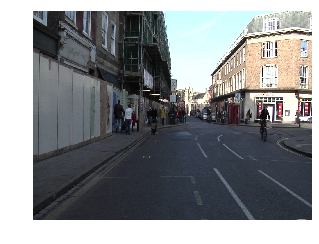

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Sometimes files has "_p" in name of it eg(0006R0_f00990_P.png),  so to convert imagename into label name we have to add "_p" in it, so we are using below function which gets filename and edit _p and put in different place.

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Mask function open the color coded image for you.

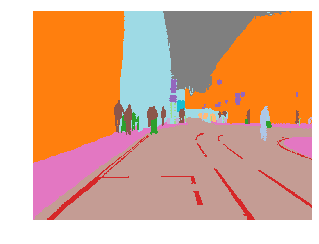

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

Then find the size of data

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 17, 17,  ..., 17, 17, 17]]]))

Below class tells us that what is code stands for for each pixel. It tell what one of those pixel means

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

#Datasets

In [0]:
size = src_size//2
free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8 # the max size of bs depends on the available GPU RAM
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


We need to create databunch

To create databunch we can go through data block api which provide imagefilelist from folder and image path.

Then we need to create label which we will get from (get_y_fn) function.

Then split data into traning and validation set.

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

Here we have list of classname i.e. classnames=codes.

If we flip our image then we need to flip color coded image also, so we use .transforms() function and pass tfms_y=True.

Create databunch with batch size using function databunch() and normalize it.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

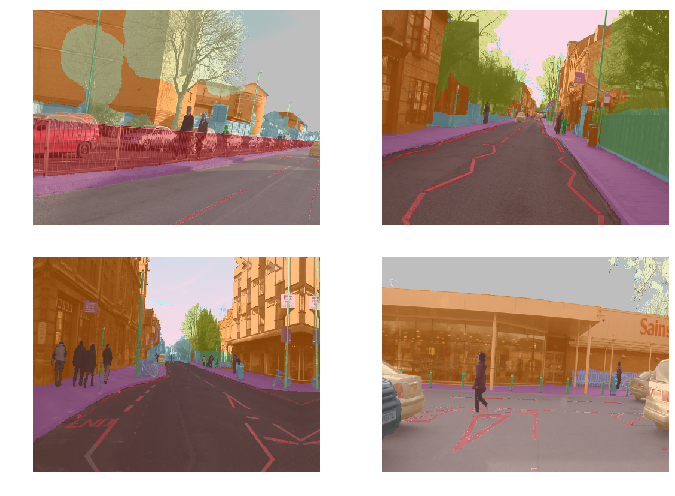

In [0]:
data.show_batch(2, figsize=(10,7))

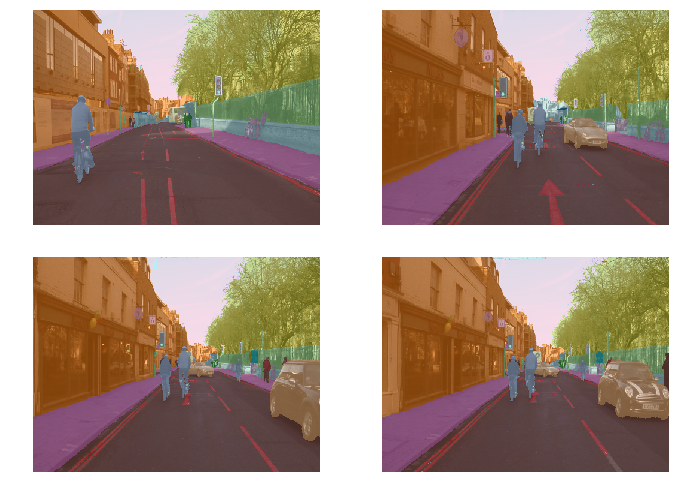

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


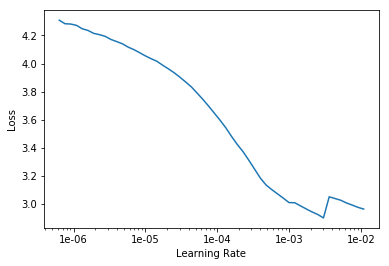

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.188915,0.793416,0.817345,01:37
1,0.833384,0.683142,0.835375,01:33
2,0.717187,0.606247,0.844748,01:33
3,0.650200,0.804641,0.775226,01:33
4,0.604895,0.616268,0.854646,01:33
5,0.616510,0.494708,0.868103,01:31
6,0.589762,0.528368,0.857004,01:31
7,0.602055,0.501386,0.854810,01:31
8,0.531412,0.443847,0.873176,01:30
9,0.463466,0.336449,0.898249,01:30


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

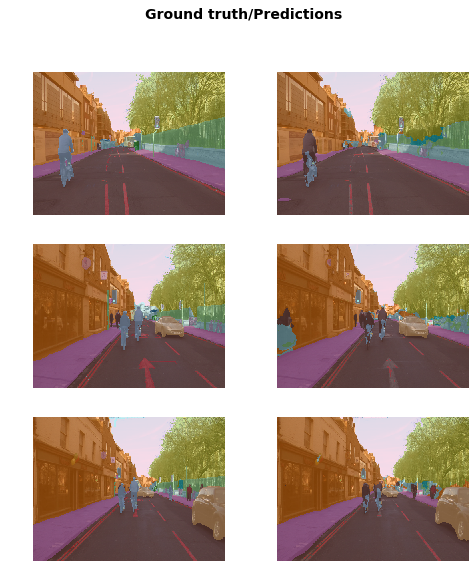

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.388382,0.327680,0.899159,01:34
1,0.385260,0.309386,0.910402,01:34
2,0.374875,0.315364,0.904538,01:35
3,0.368770,0.311853,0.906754,01:34
4,0.355203,0.305731,0.908466,01:34
5,0.345505,0.312599,0.914494,01:34
6,0.338733,0.339502,0.903587,01:34
7,0.332507,0.310014,0.917474,01:34
8,0.318591,0.294994,0.919356,01:35
9,0.310952,0.270412,0.923597,01:34


In [0]:
learn.save('stage-2');

#Go Big

If you run out of memory then restart your kernel and decrease the size of bs.

In [0]:
size = 224
free = gpu_mem_get_free_no_cache()
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 12799MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


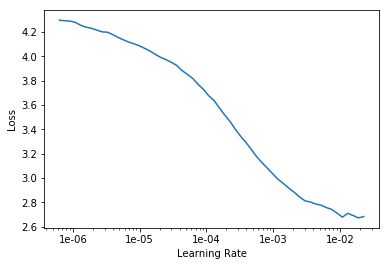

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.941304,0.836026,0.816817,00:50
1,0.720748,0.636520,0.842271,00:47
2,0.667995,0.607876,0.854381,00:47
3,0.625263,0.636052,0.846435,00:48
4,0.596595,0.556831,0.858909,00:46
5,0.563911,0.460697,0.870260,00:48
6,0.533894,0.554817,0.844111,00:48
7,0.486204,0.461839,0.874956,00:47
8,0.444086,0.342459,0.905496,00:48
9,0.365964,0.345455,0.897640,00:47


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.359323,0.335045,0.901142,00:47
1,0.348001,0.332416,0.903064,00:47
2,0.348838,0.322069,0.905591,00:46
3,0.324670,0.318454,0.907693,00:46
4,0.343784,0.309349,0.912418,00:45
5,0.327685,0.314356,0.908638,00:46
6,0.313896,0.301247,0.914449,00:47
7,0.312718,0.304779,0.912812,00:46
8,0.310719,0.300463,0.914751,00:46
9,0.313304,0.298185,0.915542,00:45


In [0]:
learn.save('stage-2-big')

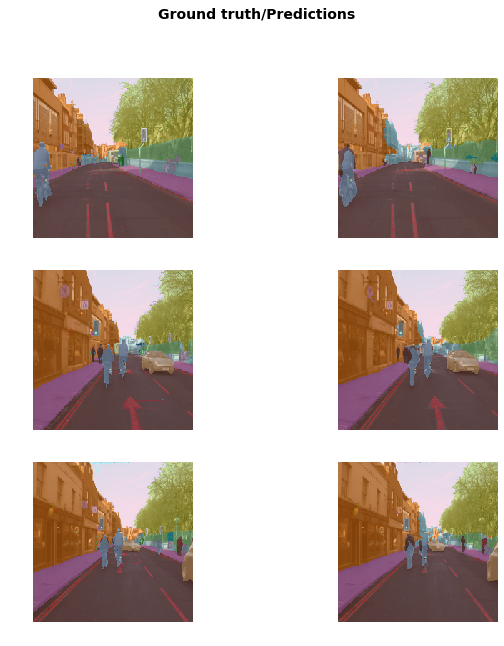

In [0]:
learn.show_results(rows=3, figsize=(10,10))